In [1]:
%matplotlib widget
import numpy as np
import scipy.io
import scipy as sc
import matplotlib.pyplot as plt
import copy
from IPython import display
from IPython.display import display as disp, HTML
from psf_helpers import *
disp(HTML("<style>.container { width:100% !important; }</style>"))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [63]:
# 20cm x 14cm and  Z scales from 0 to 1cm
#Win = scipy.io.loadmat('/Users/nick.antipa/Documents/UCSD/Research/Ocean imaging/SSML/surfaceMap.mat')
#W_raw = Win['X']*10   #Convert to mm
Win = scipy.io.loadmat('/Users/nick.antipa/Library/CloudStorage/GoogleDrive-nantipa@eng.ucsd.edu/Shared drives/Nick Transfer/Matlab code/Data/1deg_magnified_gptie_surface_1025.mat')
W_raw=Win['filtered'][500:600,500:600]*1e-3

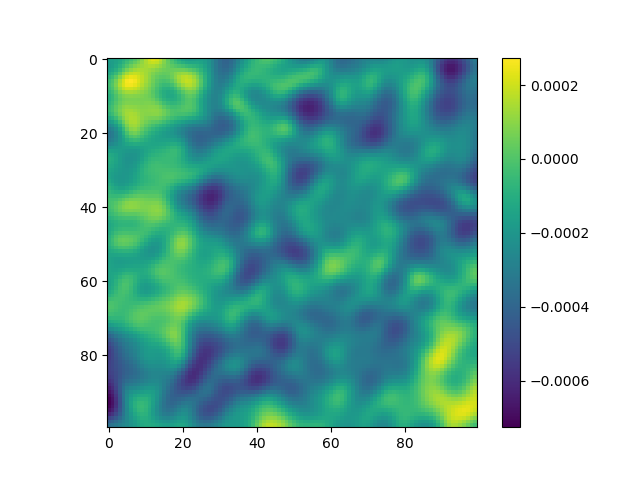

In [64]:
# Smooth the surface
smooth = 1
W_ssml = sc.ndimage.gaussian_filter(W_raw,smooth)/2
Z_ssml = sc.ndimage.gaussian_filter(W_raw,smooth)
plt.figure()
plt.imshow(W_ssml)
plt.colorbar()

In [57]:
pyy

0.006500000000000001

In [65]:
# Setup the sensor geometry
# All units in mm

fovy = 6.5e-3*100
fovx = 6.5

pyy = fovy/(np.shape(W_ssml)[0])
fovx = pyy*(np.shape(W_ssml)[1])


sensor = {
    'px': pyy,   #Pixel size
    'npix':[np.shape(W_ssml)[n] for n in range(len(np.shape(W_ssml)))]   #Number of pixels
    }

sensor['fov'] = [sensor['npix'][0]*sensor['px'], sensor['npix'][1]*sensor['px']]

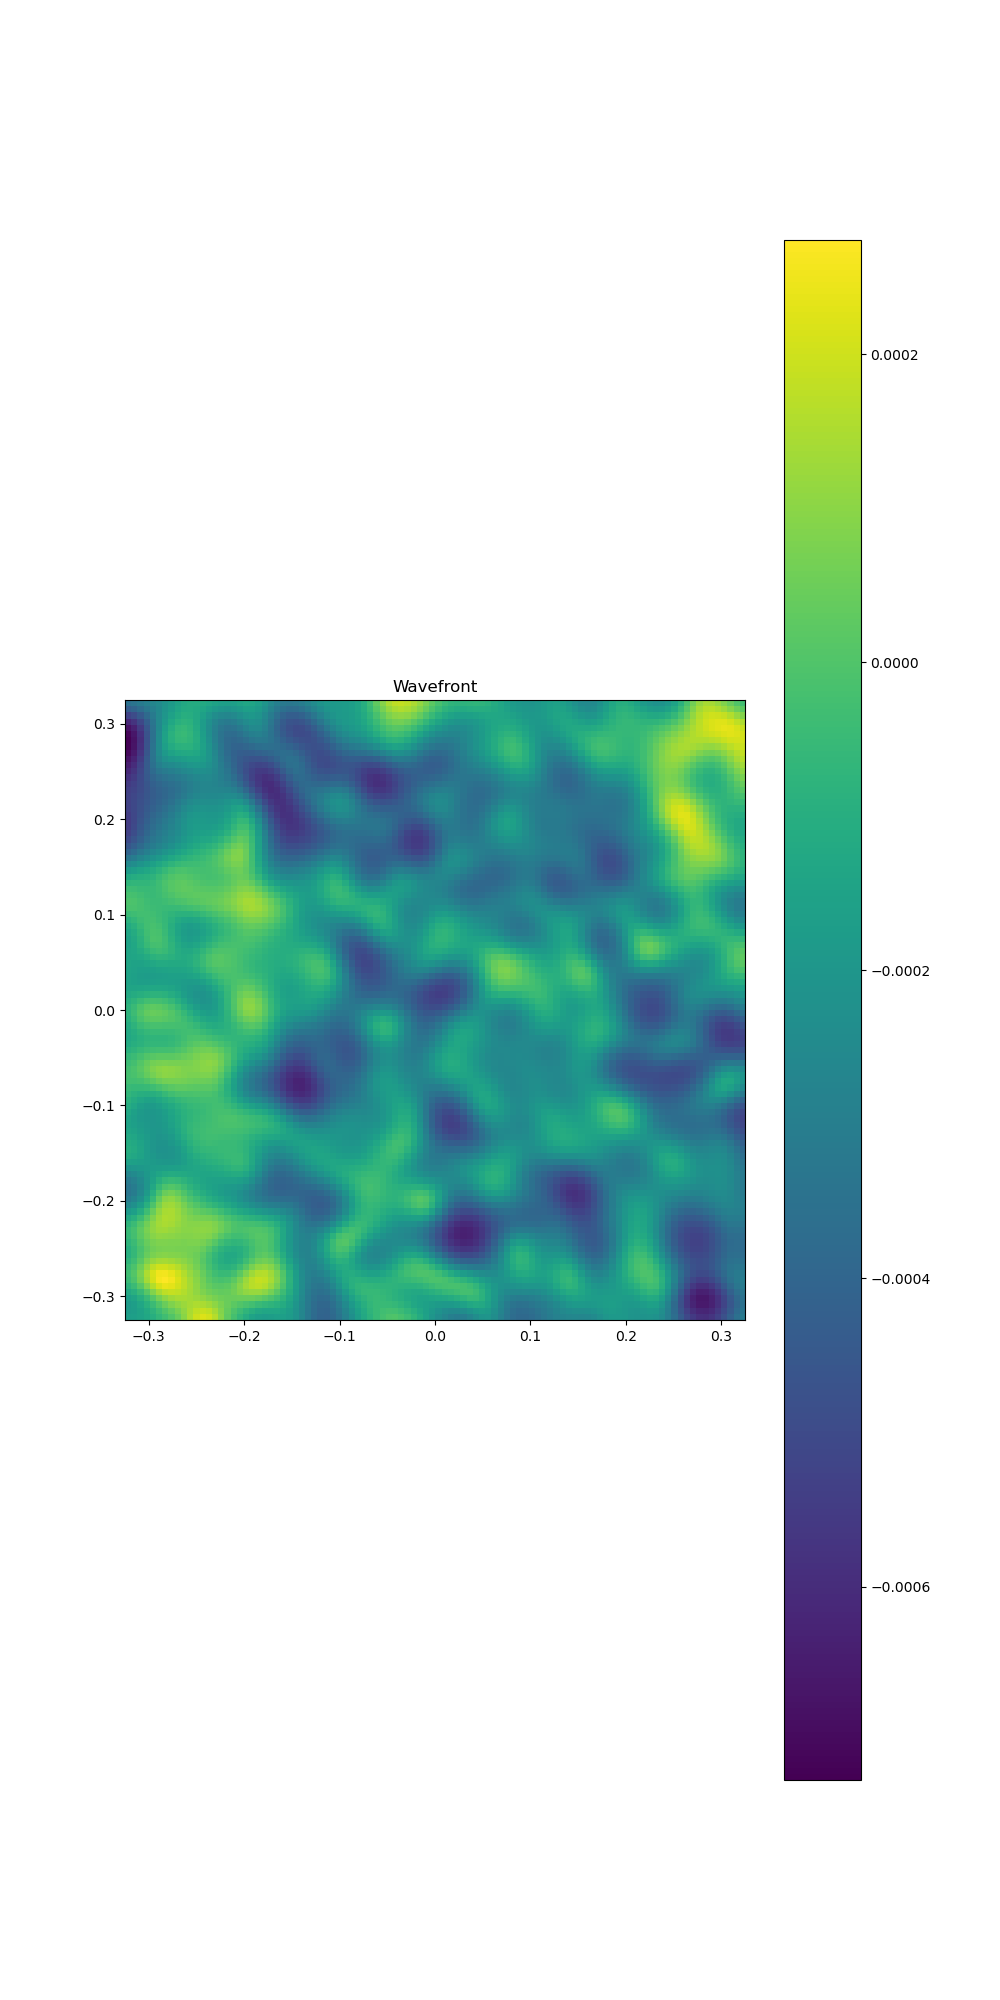

In [76]:
lam = 550e-6   #Wavelength
# t = 30-100 is good for ssml
pupil = {
    'ca':[fovy, fovx],   # Clear aperture in x and y
    'efl' : 10000000000,   #Focal lenght, used for spherical wavefront component calculation.
    't': 2,    #Distance to sensor
    'ap_type' : 'rect'    #Aperture shape. 'circ' or 'rect'
}

rhomax = pupil['ca'][0]/2
xtent = [-sensor['fov'][1]/2, sensor['fov'][1]/2]
ytent = [-sensor['fov'][0]/2, sensor['fov'][0]/2]
figextent = [xtent[0], xtent[1], ytent[0], ytent[1]]

fy_sc, fx_sc = np.gradient(W_ssml, sensor['px'])
# fx_sc = fx/sensor['px']
# fy_sc = fy/sensor['px']

x2idx = lambda x,fovx:(np.round((x+fovx/2)/sensor['px'])).astype('int')

rx = np.r_[0:sensor['npix'][1]]*sensor['px'] - sensor['npix'][1]*sensor['px']/2
ry = np.r_[0:sensor['npix'][0]]*sensor['px'] - sensor['npix'][0]*sensor['px']/2
[Rx,Ry] = np.meshgrid(rx,ry)

W = lambda x,y:W_ssml[x2idx(y,fovy), x2idx(x,fovx)]
fx_func = lambda x,y:fx_sc[x2idx(y,fovy), x2idx(x,fovx)]
fy_func = lambda x,y:fy_sc[x2idx(y,fovy), x2idx(x,fovx)]
pupil['W_aber'] = W
pupil['fx_aber'] = fx_func
pupil['fy_aber'] = fy_func



W_sph = genSph(pupil['efl']);
pupil['W_sph'] = W_sph[0]
pupil['fx_sph'] = W_sph[1]
pupil['fy_sph'] = W_sph[2]

wx = 1000    #x frequency
wy = 500    #y frequency
W_sin = genSin(wx,wy,0.)
pupil['W_sin'] = W_sin[0]
pupil['fx_sin'] = W_sin[1]
pupil['fy_sin'] = W_sin[2]

plt.figure(figsize=(10,20))
plt.imshow(pupil['W_aber'](Rx,Ry)+pupil['W_sph'](Rx,Ry),
          extent=figextent,
          origin='lower')
plt.title('Wavefront')
plt.colorbar()

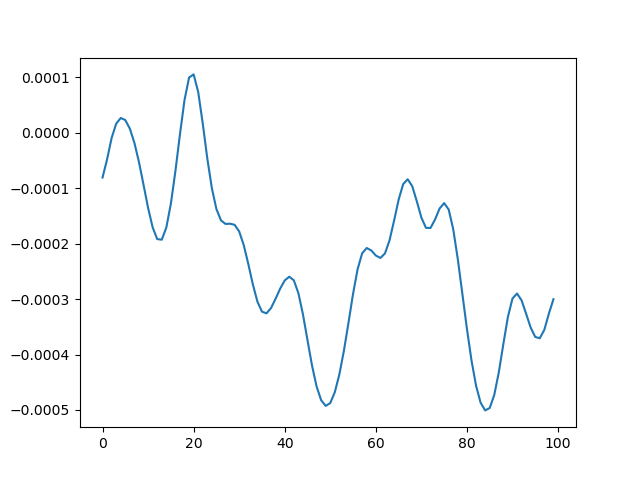

In [77]:
plt.close()
plt.figure()
plt.plot(pupil['W_aber'](rx,-0))

In [78]:
Nrays = 100000
xo = []
yo = []
opl = []
Wo = []
rhox_list = []
rhoy_list = []
for k in range(Nrays):
    
    # Pick a random location on the surface
    if pupil['ap_type'] == 'circ':
        thx = np.random.rand(1)*2*np.pi
        rho = pupil['ca'][0]/2*np.sqrt(np.random.rand(1))
        rhox = rho*np.sin(thx)
        rhoy = rho*np.cos(thx)
    elif pupil['ap_type'] == 'rect':
        rhox = np.clip(pupil['ca'][1]*(np.random.rand(1) - 0.5),
                       rx[0],rx[-1])
        rhoy = np.clip(pupil['ca'][0]*(np.random.rand(1) - 0.5),
                       ry[0],ry[-1])

    if k%100 == 0:
        display.clear_output(wait=True)
        print(np.floor(k/Nrays*1000)/10," pct complete.")
    # Launch a ray toward the sensor
    rays_out = trace_ray(rhox, rhoy, pupil,debug=False)
    rhox_list.append(rhox)
    rhoy_list.append(rhoy)
    xo.append(rays_out[0])
    yo.append(rays_out[1])
    opl.append(rays_out[2])
    Wo.append(rays_out[3])
    # Scatter plot ray output positoins


99.9  pct complete.


(-0.3799933477763404,
 0.365659558190512,
 -0.3771244038185463,
 0.3675265150023229)

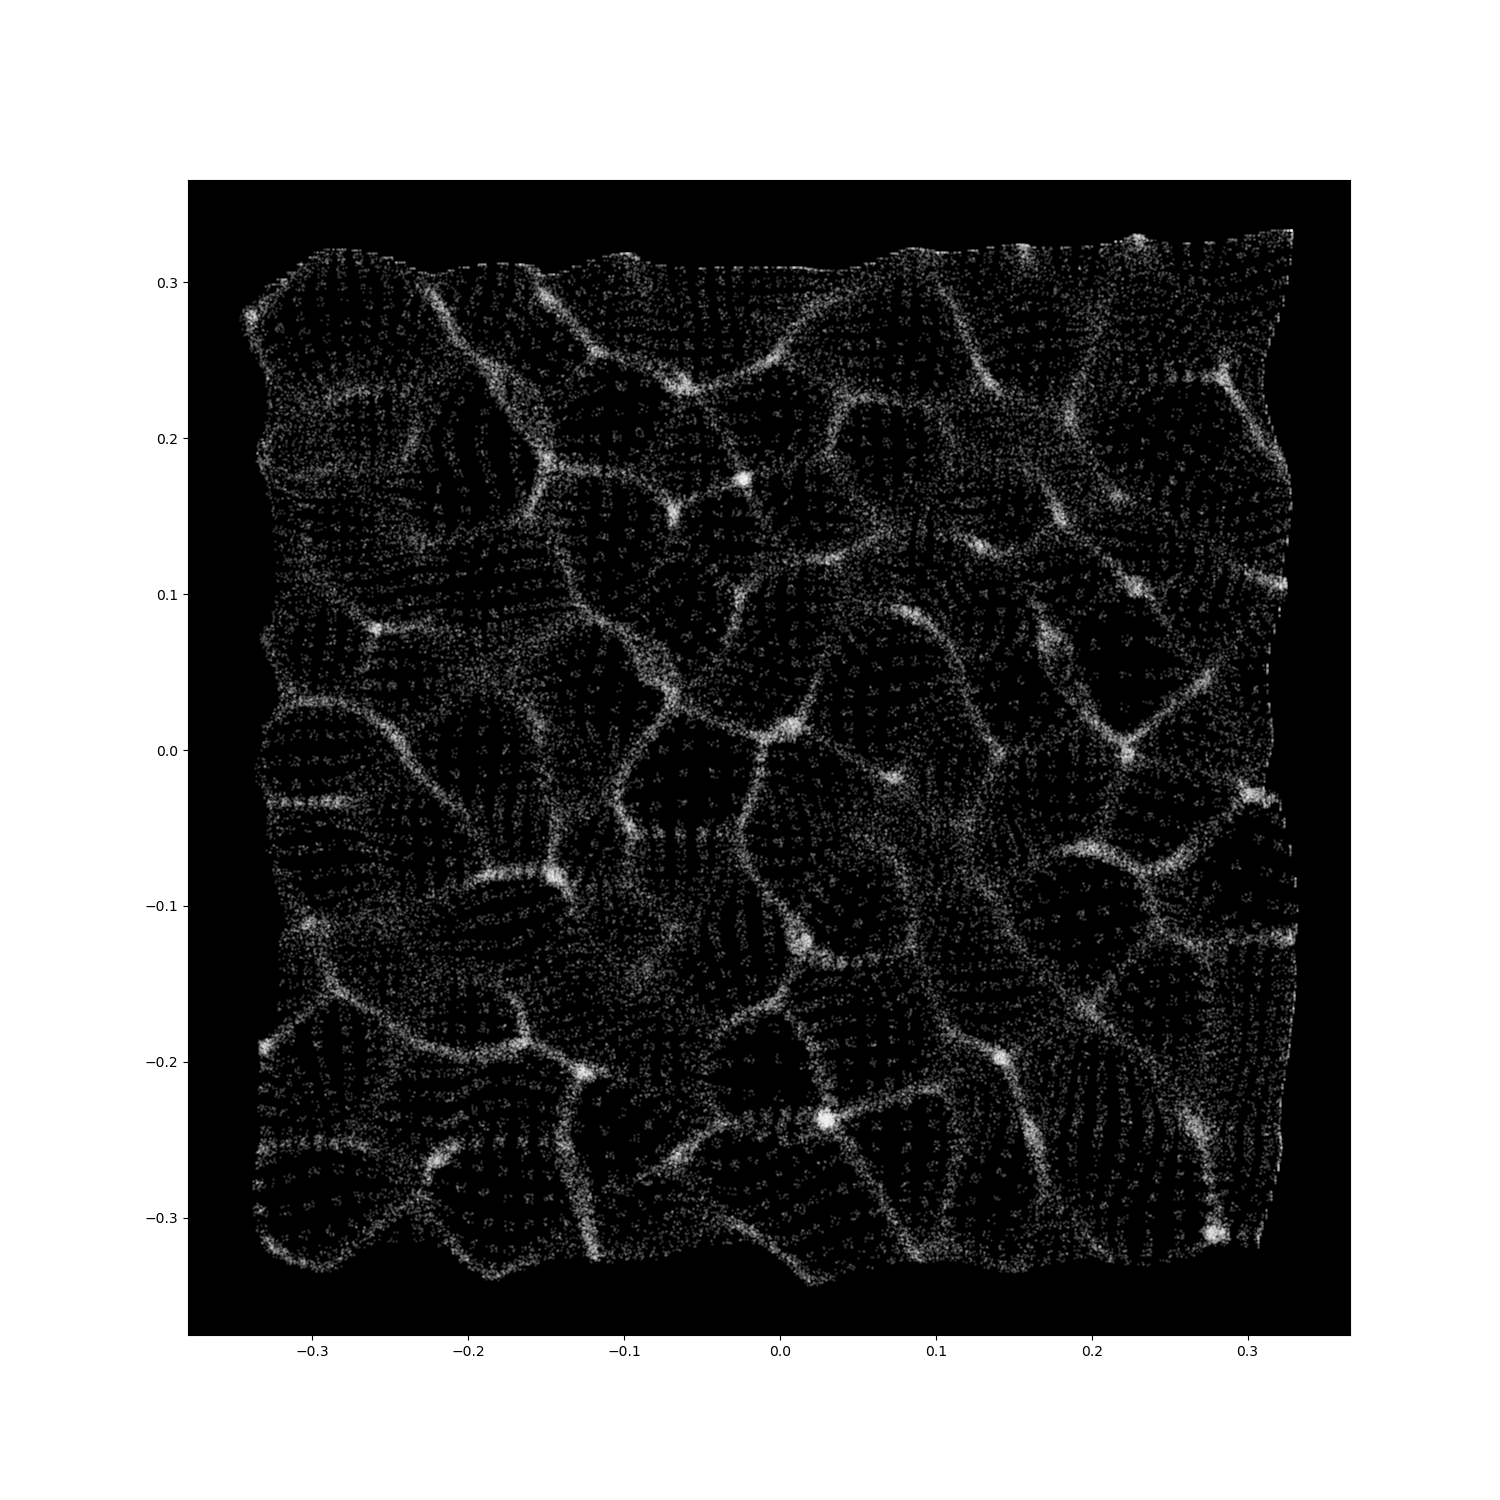

In [79]:
# Scatter plot of rays
f = plt.figure(figsize=(15,15))
ax = plt.gca()
ax.set_facecolor((0,0,0))
plt.scatter(xo,yo,s=5,c=[[1, 1, 1]],marker='.',alpha=.1)
plt.xlim(xtent)
plt.ylim([-sensor['fov'][0]/2, sensor['fov'][0]/2])
ax.axis('equal')


In [84]:
sensor2 = copy.deepcopy(sensor)
sensor2['px'] = sensor['px']//2
sensor2['npix'] = [sensor['npix'][n]*2 for n in range(2)]
H, xe, ye = rays_to_im(xo, yo, sensor2)


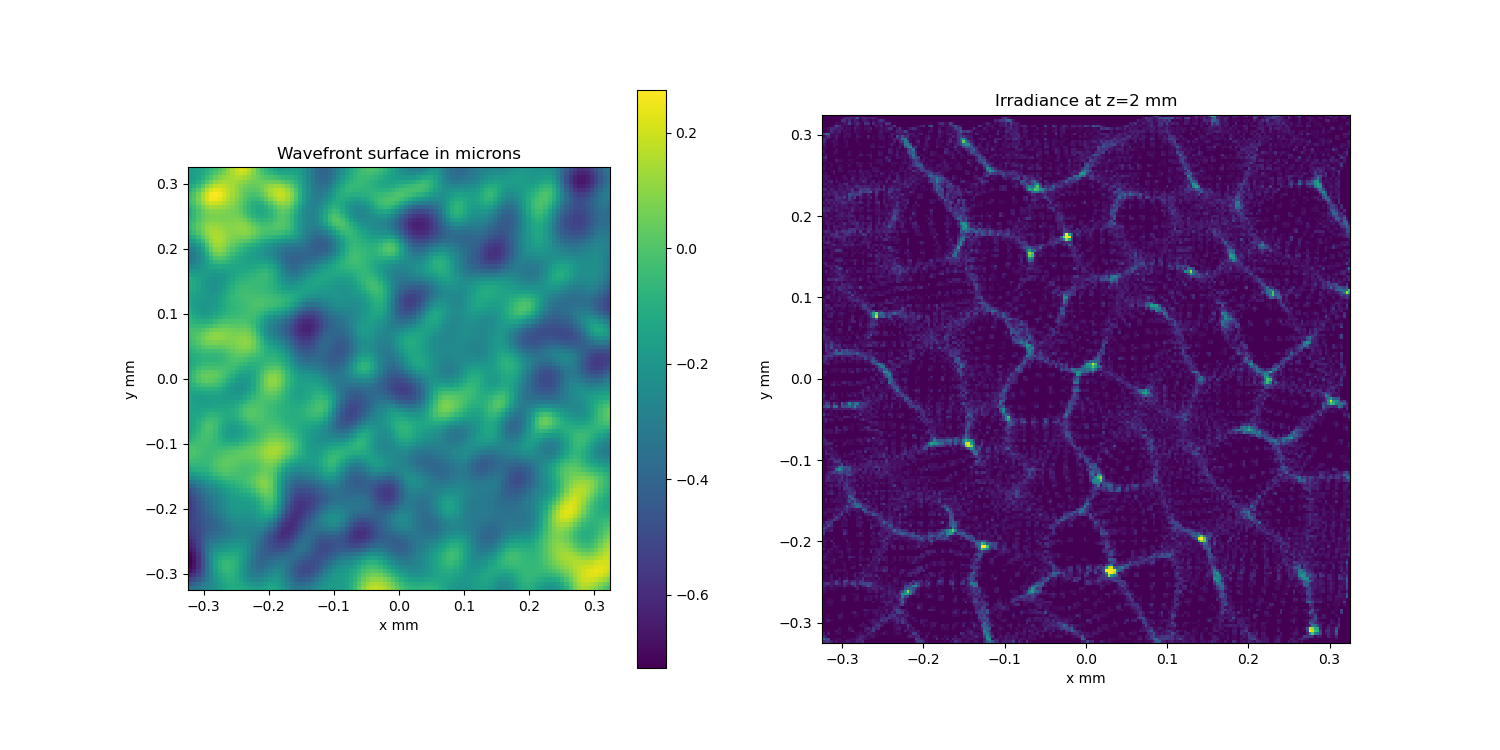

In [99]:
fig, ax = plt.subplots(1,2,figsize=(15,7.5))

ax[1].imshow(H.transpose()[::-1], extent=figextent,interpolation='none',vmax=50)
ax[1].set_title('pixels')
ax[1].set_xlabel('x mm')
ax[1].set_ylabel('y mm')
ax[1].set_title('Irradiance at z=' + str(pupil['t']) + ' mm')

im = ax[0].imshow(W_ssml*1000,extent=figextent)
ax[0].set_xlabel('x mm')
ax[0].set_ylabel('y mm')
ax[0].set_title('Wavefront surface in microns')
plt.colorbar(im, ax=ax[0])



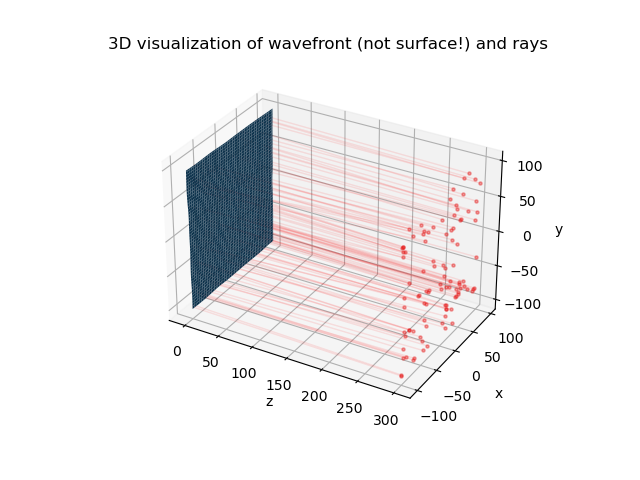

In [11]:
# Plot the wavefront (blue) and rays (red)
#%matplotlib notebook
Nrays_vis = 100
f2 = plt.figure()
ax2 = plt.axes(projection='3d')
W_total = pupil['W_sph'](Rx,Ry) + pupil['W_aber'](Rx,Ry)



for n in range(Nrays_vis):
    ax2.plot([Wo[n][0], pupil['t']], [rhox_list[n][0], xo[n][0]], [rhoy_list[n][0], yo[n][0]],color='r',linewidth=1,alpha=.1)
    ax2.scatter(pupil['t'], xo[n][0], yo[n][0],color=[.9, .1, .1],alpha=.4,s=5)

    
ax2.plot_surface(W_total,Rx,Ry,edgecolor='none',linewidth=0)


plt.xlabel('z')
plt.ylabel('x')
ax2.set_zlabel('y')
ax2.set_title('3D visualization of wavefront (not surface!) and rays')
#ax2.set_aspect([np.ptp(Rx), np.ptp(Ry), pupil['t']])
ax2.set_aspect('equal')


KeyboardInterrupt: 

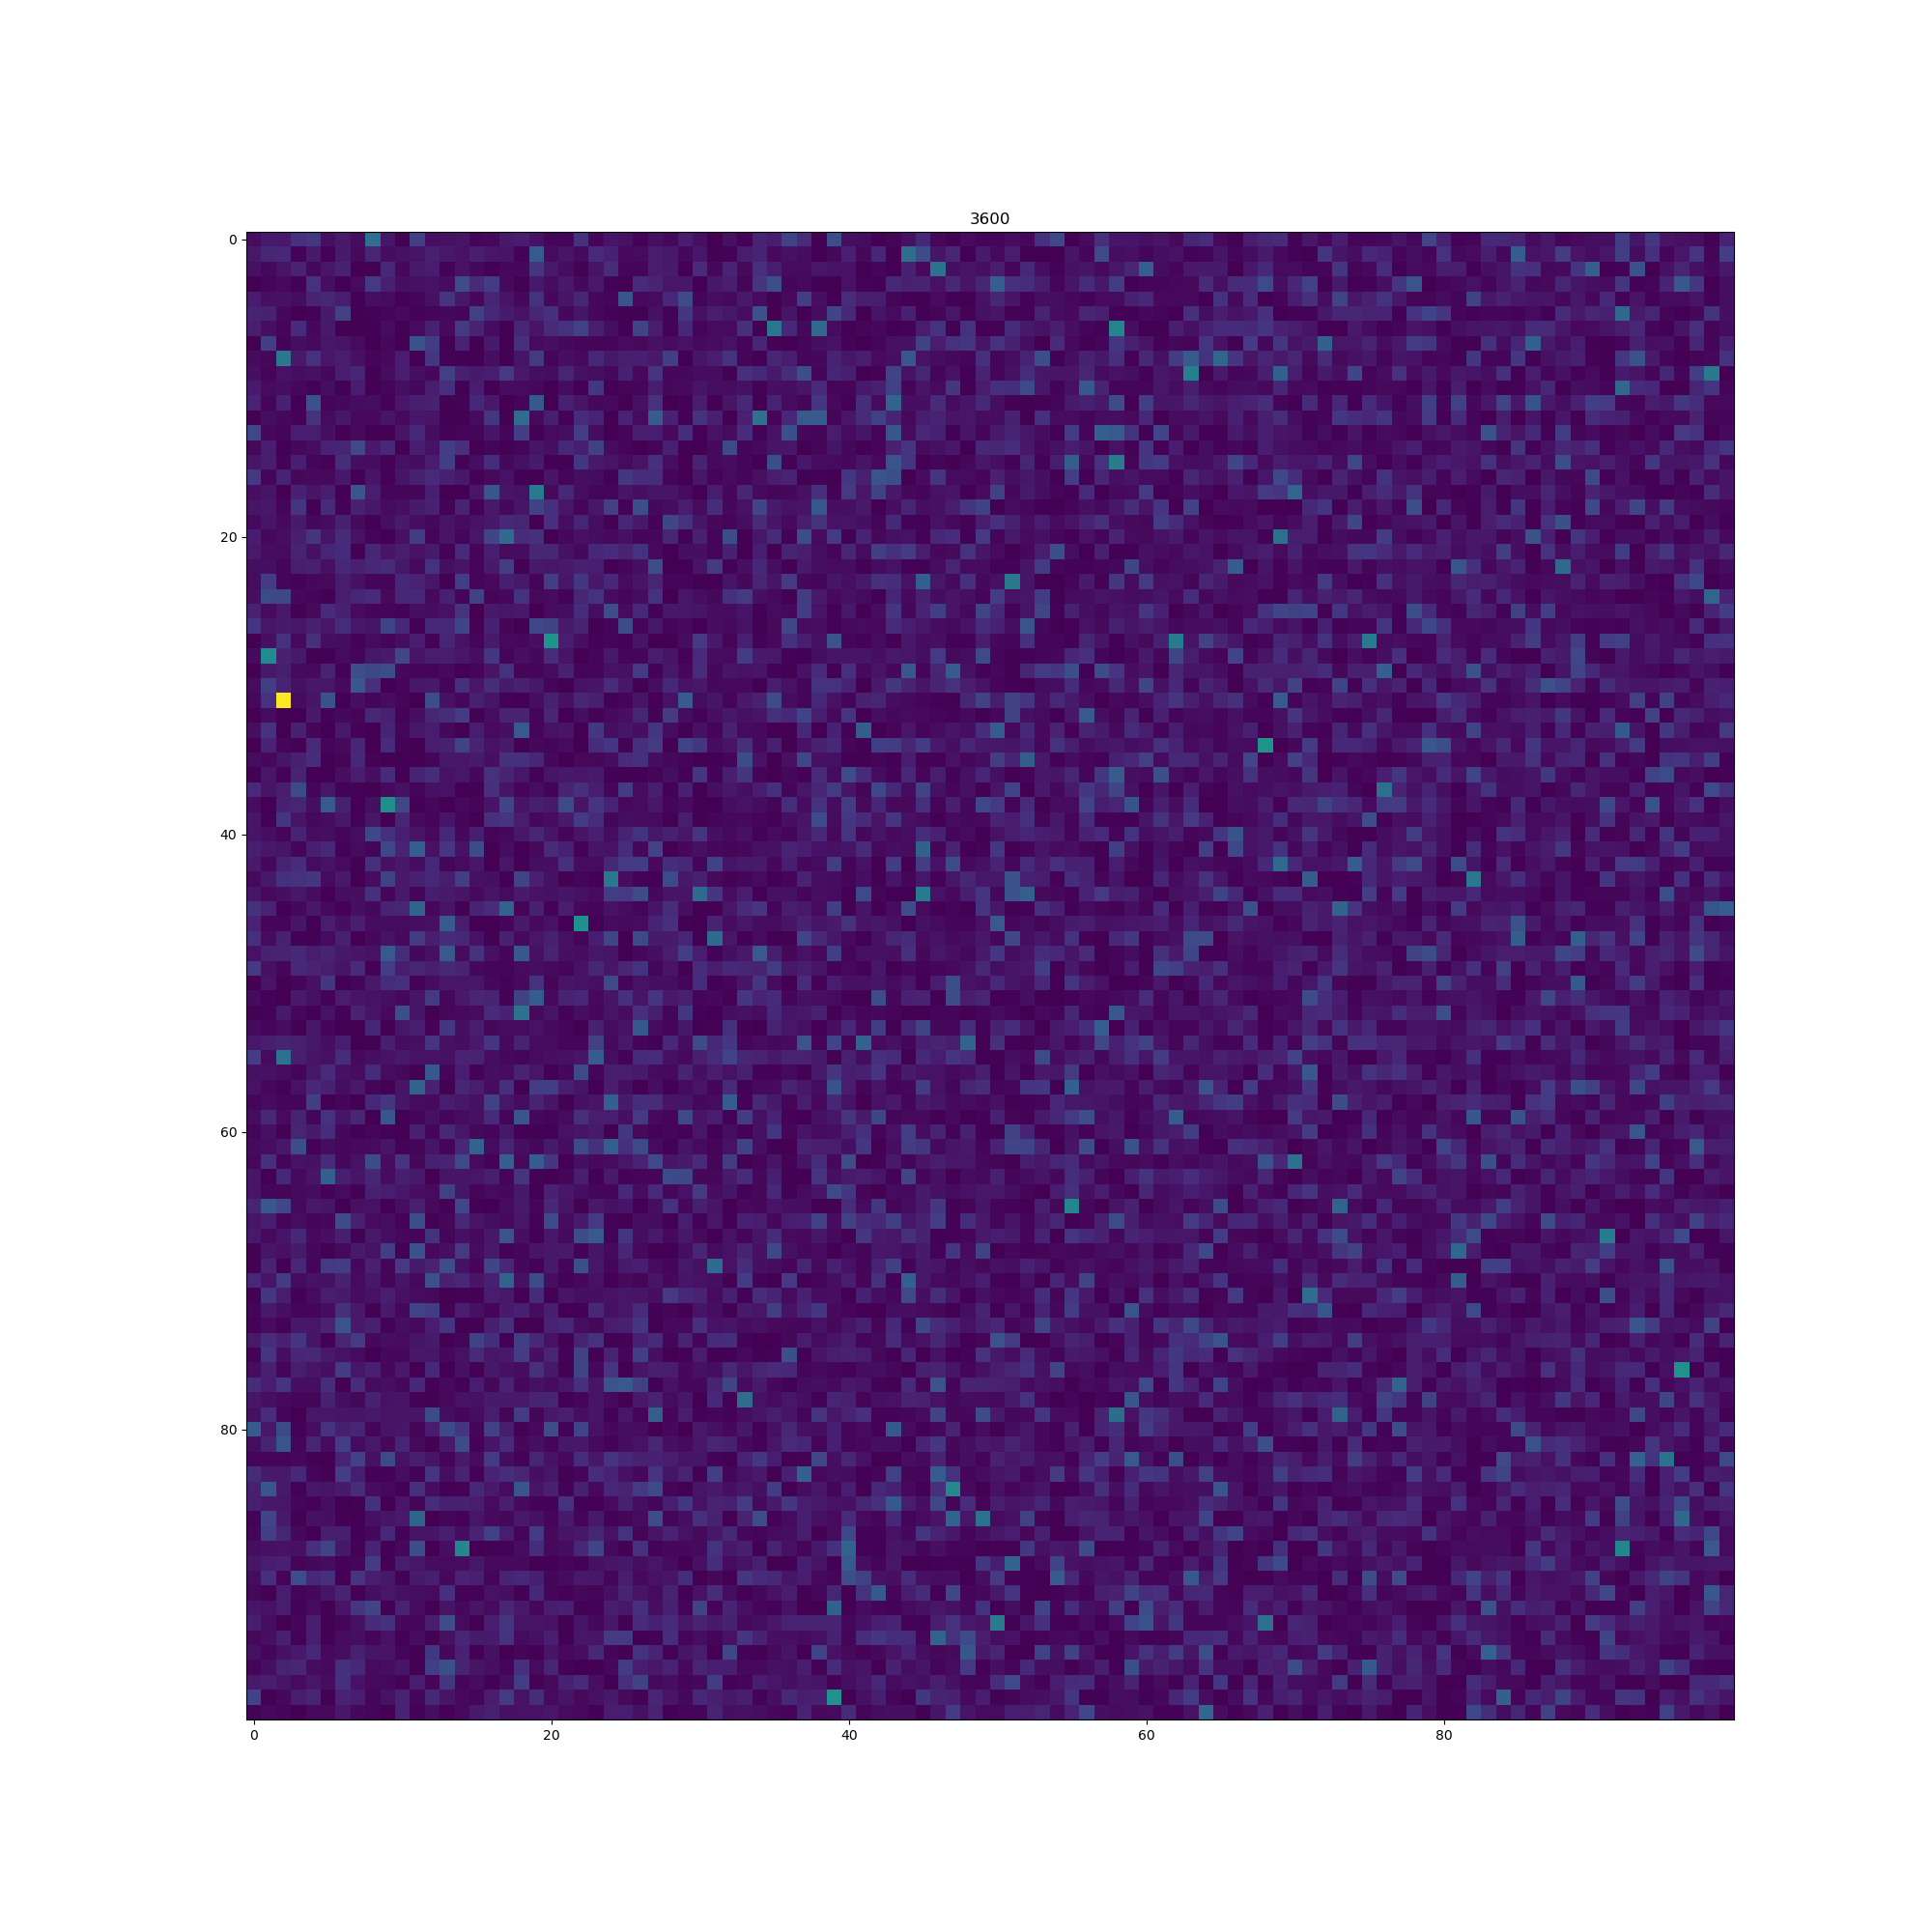

In [13]:
U_huygens = huygens(pupil, sensor,  5000, lam, rx, ry)